# Computing mass functions, halo biases and concentrations
This notebook illustrates how to compute mass functions, halo biases and concentration-mass relations with CCL, as well as how to translate between different mass definitions.

In [1]:
import numpy as np
from matplotlib import pyplot as plt
import pyccl as ccl
import logging
mpl_logger = logging.getLogger('matplotlib')
mpl_logger.setLevel(logging.WARNING)
pil_logger = logging.getLogger('PIL')

## Preliminaries
Generate a cosmology object and a few mass/redshift arrays

In [2]:
# Cosmology
cosmo = ccl.Cosmology(Omega_b=0.0492, Omega_c=0.2650, h=0.6724, A_s=2.2065e-09, n_s=0.9645)

# Array of masses
m_arr = np.geomspace(1.01E12,1E15,128)/cosmo['h']

# Array of redshifts
z_arr = np.linspace(0.,1.,16)

## Mass definitions
CCL admits 3 different classes of definitions:
- Spherical overdensity (SO). The mass is defined as that enclosed by a radius within which the mean density is a factor $\Delta$ larger than the matter or critical density ($x$ is either $M$ or ${\rm crit}$: 

\begin{equation}
   M_{\Delta,x} = \frac{4\pi}{3}\Delta\rho_x R_{\Delta,x}^3
\end{equation},
- Virial spherical overdensity. The same as SO for the specific choice $\Delta=\Delta_{\rm vir}(z)$ and $x={\rm critical}$, where $\Delta_{\rm vir}$ is the virial overdensity, which CCL computes from Brian & Norman 1998.
- Friends-of-friends masses (fof).

CCL is able to translate masses assuming an NFW profile. This is only an approximation, and it's actually better to make sure you use consistent mass definitions throughout, but this functionality is provided for convenience.

These mass definition objects can then be passed around to all halo-model functions to make sure masses are treated consistently.



In [3]:
# Delta=200 (matter).
hmd_200m = ccl.halos.MassDef200m

# Delta=200 (critical).
hmd_200c = ccl.halos.MassDef200c

# Delta=500 (matter).
hmd_500m = ccl.halos.MassDef(500, 'matter')

# Virial overdensity
hmd_vir = ccl.halos.MassDefVir

# FoF mass definition
hmd_fof = ccl.halos.MassDefFof

Note that associating concentration-mass relations with mass definitions is only necessary if you'll want to translate between different mass definitions. Otherwise, you can use any concentration-mass relation you want for a given mass definition as we show further down (even if that c(M) relation is not the one you used to initialize the corresponding mass definition object).

## Mass functions
Mass functions are computed through classes that inherit from the `MassFunc` class. CCL supports a wide variety of mass function parametrizations, but more can be created following the instructions in the documentation.

All mass functions have a mass definition attached to them. Some mass functions support a range of mass definitions, and you can select which one you want when instantiating the class. All mass functions have default mass definitions, which are used if `None` is passed (which is the case below).

initialize cosmo_class
Initialize pklin emulator
initialize propagator emulator
Initialize sigma_d emulator
initialize cross-correlation emulator
initialize auto-correlation emulator
Initialize sigmaM emulator
initialize xinl emulator


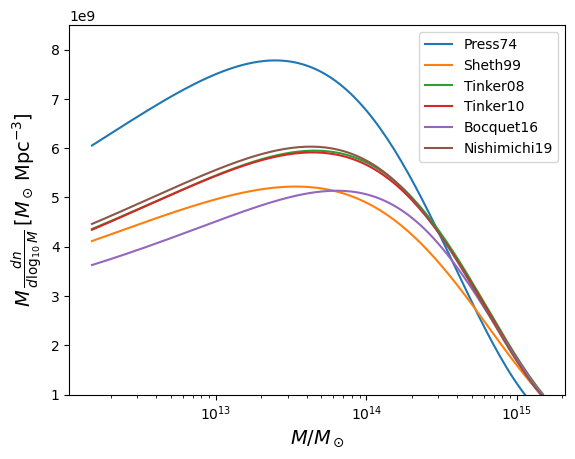

In [6]:
hmfs = []
# Press & Schechter mass function
hmfs.append(ccl.halos.MassFuncPress74(mass_def=hmd_fof))

# Sheth & Tormen mass function
hmfs.append(ccl.halos.MassFuncSheth99(mass_def=hmd_fof))

# Tinker 2008 mass function
hmfs.append(ccl.halos.MassFuncTinker08(mass_def=hmd_200m))

# Tinker 2010 mass function
hmfs.append(ccl.halos.MassFuncTinker10(mass_def=hmd_200m))

# Bocquet 2016 mass function
hmfs.append(ccl.halos.MassFuncBocquet16(mass_def=hmd_200m))

# Nishimichi 2019 mass function
# To use this mass function you need the dark emulator: 
# https://dark-emulator.readthedocs.io/en/latest/
hmfs.append(ccl.halos.MassFuncNishimichi19(mass_def=hmd_200m,extrapolate=True))

# Let's plot all of them at z=0
plt.figure()
for mf in hmfs:
    nm = mf(cosmo, m_arr, 1.)
    plt.plot(m_arr,
             m_arr * nm, label=mf.name)
plt.xscale('log')
plt.ylim([1E9,8.5E9])
plt.legend()
plt.xlabel(r'$M/M_\odot$', fontsize=14)
plt.ylabel(r'$M\,\frac{dn}{d\log_{10}M}\,[M_\odot\,{\rm Mpc}^{-3}]$',
           fontsize=14);

Let's explore the time evolution of the mass function

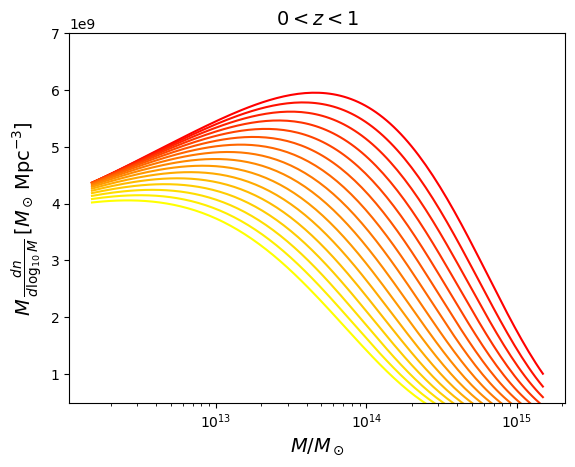

In [7]:
# Look at time evolution
from matplotlib.pyplot import cm

hmf_200m = ccl.halos.MassFuncTinker08(mass_def=hmd_200m)
plt.figure()
plt.title(r'$0<z<1$',fontsize=14)
for z in z_arr:
    nm = hmf_200m(cosmo, m_arr, 1./(1+z))
    plt.plot(m_arr,
             m_arr * nm, c=cm.autumn(z))
plt.xscale('log')
plt.ylim([5E8,7E9])
plt.xlabel(r'$M/M_\odot$',fontsize=14)
plt.ylabel(r'$M\,\frac{dn}{d\log_{10}M}\,[M_\odot\,{\rm Mpc}^{-3}]$',
           fontsize=14);

## Halo bias
Similar comments apply to the different halo bias parametrizations supported by CCL.

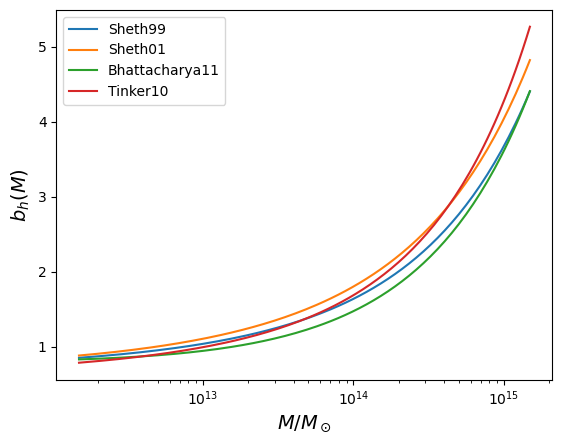

In [8]:
hbfs = []
# Sheth & Tormen 1999
hbfs.append(ccl.halos.HaloBiasSheth99())

# Sheth & Tormen 2001
hbfs.append(ccl.halos.HaloBiasSheth01())

# Bhattacharya 2011
hbfs.append(ccl.halos.HaloBiasBhattacharya11())

# Tinker 2010
hbfs.append(ccl.halos.HaloBiasTinker10())

# Let's plot all of them at z=0
plt.figure()
for bf in hbfs:
    bm = bf(cosmo, m_arr, 1.)
    plt.plot(m_arr, bm, label=bf.name)
plt.xscale('log')
plt.legend()
plt.xlabel(r'$M/M_\odot$', fontsize=14)
plt.ylabel(r'$b_h(M)$', fontsize=14);

## Concentration-mass relation
Concentration-mass relations work in a similar way

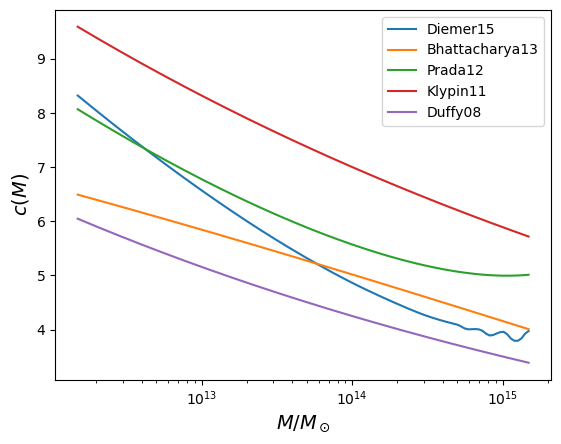

In [9]:
cmrs = []
# Diemer 2015
cmrs.append(ccl.halos.ConcentrationDiemer15())

# Bhattacharya 2013
cmrs.append(ccl.halos.ConcentrationBhattacharya13())

# Prada 2012
cmrs.append(ccl.halos.ConcentrationPrada12())

# Klypin 2011
cmrs.append(ccl.halos.ConcentrationKlypin11())

# Duffy 2008
cmrs.append(ccl.halos.ConcentrationDuffy08())

# Let's plot all of them at z=0
plt.figure()
for cmr in cmrs:
    cm = cmr(cosmo, m_arr, 1.)
    plt.plot(m_arr, cm, label=cmr.name)
plt.xscale('log')
plt.legend()
plt.xlabel(r'$M/M_\odot$', fontsize=14)
plt.ylabel(r'$c(M)$', fontsize=14);

## Convenience functions
It is possible to select mass functions, halo biases and concentration-mass relation from their name as follows

In [10]:
nm = ccl.halos.MassFunc.from_name('Tinker08')
bm = ccl.halos.HaloBias.from_name('Tinker10')
cm = ccl.halos.Concentration.from_name('Duffy08')
print(nm)
print(bm)
print(cm)

<class 'pyccl.halos.hmfunc.tinker08.MassFuncTinker08'>
<class 'pyccl.halos.hbias.tinker10.HaloBiasTinker10'>
<class 'pyccl.halos.concentration.duffy08.ConcentrationDuffy08'>


## Mass conversion
The lines below show how to convert between different mass definitions (and the consequences of doing so). First, we generate mass function objects for $\Delta=200$ and $500$. Then, we compute the mass function using both parametrizations, but for masses defined using $\Delta=200$ (the $\Delta=500$ mass function will use the concentration-mass relation to translate masses from $\Delta=200$ to $\Delta=500$ automatically). As you can see, doing so incurrs a systematic error of up to ~20%.

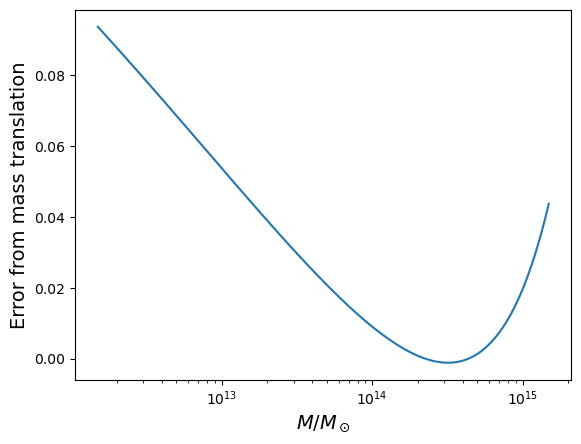

In [11]:
# Let's define a mass function object for Delta = 500 (matter)
hmf_500m = ccl.halos.MassFuncTinker08(mass_def=hmd_500m)

# Now let's compare the mass function parametrized for 200 (matter)
# with the mass function parametrized for 500 (matter) but
# translated to 200 (matter)
hmf_200m = ccl.halos.MassFuncTinker08(mass_def=hmd_200m)

mass_trans = ccl.halos.mass_translator(mass_in=hmd_200m, mass_out=hmd_500m, 
                                       concentration=ccl.halos.ConcentrationDuffy08(mass_def=hmd_200m))

m500 = mass_trans(cosmo, m_arr, 1.)

nM_200m = hmf_200m(cosmo, m_arr, 1.)
nM_200m_trans = hmf_500m(cosmo, m500, 1.)

plt.figure()
plt.plot(m_arr, nM_200m_trans/nM_200m-1)
plt.xscale('log')
plt.xlabel(r'$M/M_\odot$',fontsize=14)
plt.ylabel('Error from mass translation',
           fontsize=14);